<a href="https://colab.research.google.com/github/Stavroskiig/basic-mnist-nn/blob/main/basic_mnist_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and import dependencies like TensorFlow Datasets, which provides several sample datasets to work with.



In [ ]:
!pip install -U tensorflow_datasets

In [ ]:
import tensorflow as tf

In [ ]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Import the Fashion MNIST dataset (70,000 grayscale images in 10 categories at low resolution of 28  ×  28 pixels).

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Each image is a 28 $\times$ 28 array, with pixel values in the range `[0, 255]`. The *labels* are an array of integers within the range `[0, 9]`. These correspond to the *class* of clothing the image represents. Each image is mapped to a single label. Since the *class names* are not included with the dataset we store them here to use them for plotting.

In [ ]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Explore the format of the dataset

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So, we create a normalization function to apply it to each image in the test and train datasets.

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

Plot an image

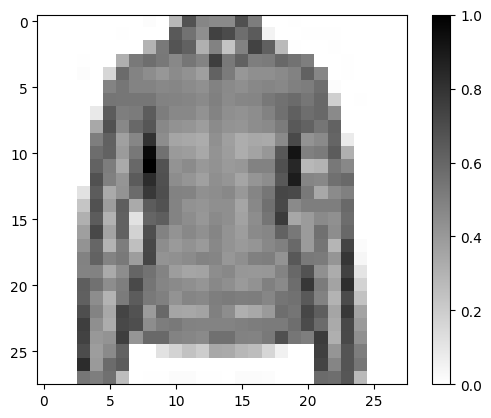

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image.

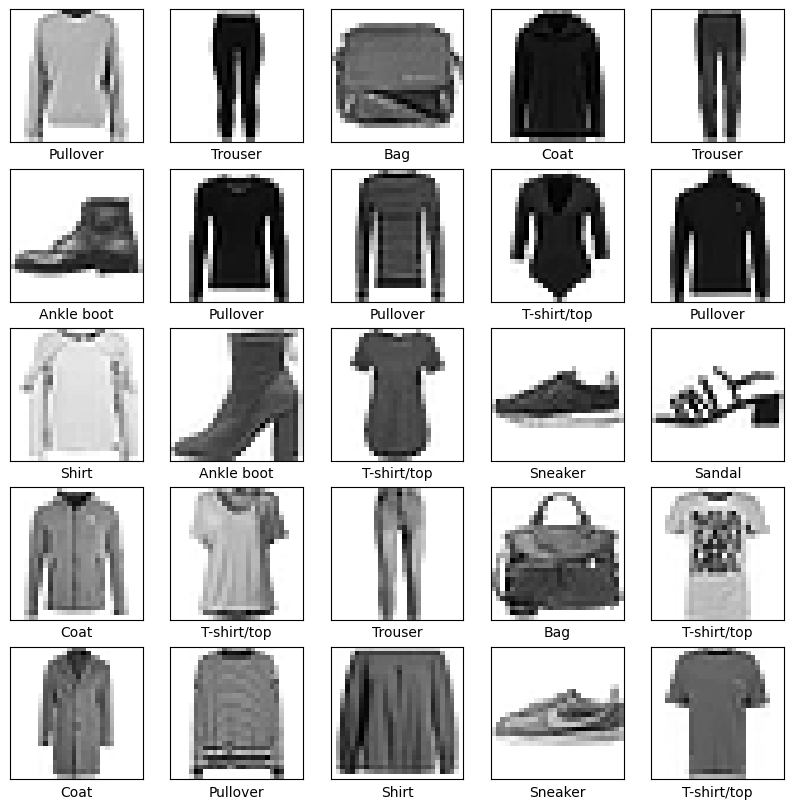

In [ ]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

# 1. Use a basic model

Setup the 3 layers: input (flattened 28x28 array, hidden (128 neurons), output (10-node softmax layer).

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Compile the model.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Train the model.

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 30s 9ms/step - loss: 0.4907 - accuracy: 0.8295
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3741 - accuracy: 0.8650
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3316 - accuracy: 0.8781
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3130 - accuracy: 0.8857
Epoch 5/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2918 - accuracy: 0.8921


Evaluate the accuracy.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 4s 11ms/step - loss: 0.3455 - accuracy: 0.8765
Accuracy on test dataset: 0.8765000104904175


Make predictions about some images.

In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 180ms/step


In [ ]:
predictions.shape

(32, 10)

Look at the first prediction:

In [ ]:
predictions[0]

array([4.5310462e-05, 3.1654176e-06, 1.8824980e-02, 3.5015779e-07,
       9.6515769e-01, 4.8870558e-10, 1.5956419e-02, 8.8470573e-09,
       1.1972530e-05, 1.7331315e-08], dtype=float32)

Highest confidence value:

In [ ]:
np.argmax(predictions[0])

4

The model is confident that this image is a coat, or `class_names[4]`. Indeed it is a coat:

In [ ]:
test_labels[0]

4

Full set of 10 class predictions:

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th and 12th images, predictions, and prediction array.

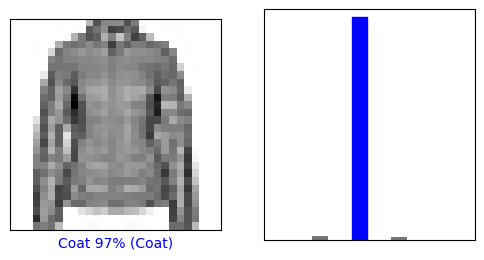

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

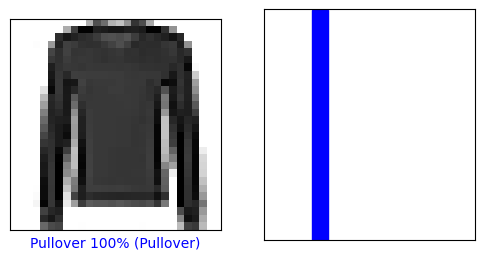

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Plot several images with their predictions.

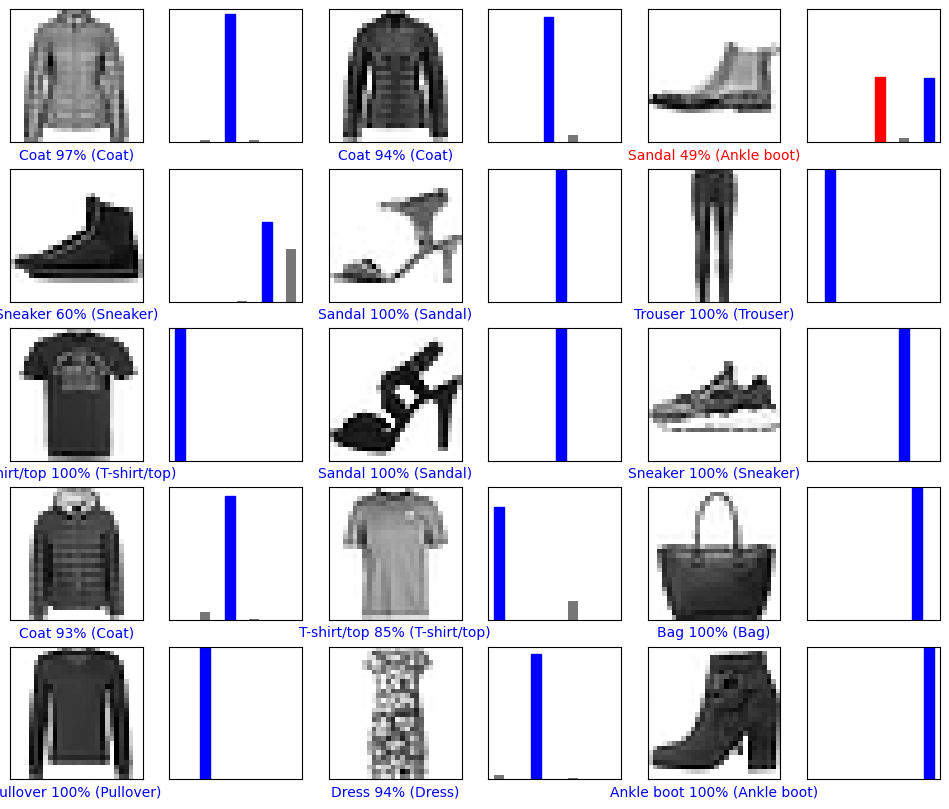

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Use the trained model to make a prediction about a single image.

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


Add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Predict the image:

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 58ms/step
[[4.5310462e-05 3.1654147e-06 1.8824972e-02 3.5015782e-07 9.6515775e-01
  4.8870374e-10 1.5956396e-02 8.8470076e-09 1.1972530e-05 1.7331283e-08]]


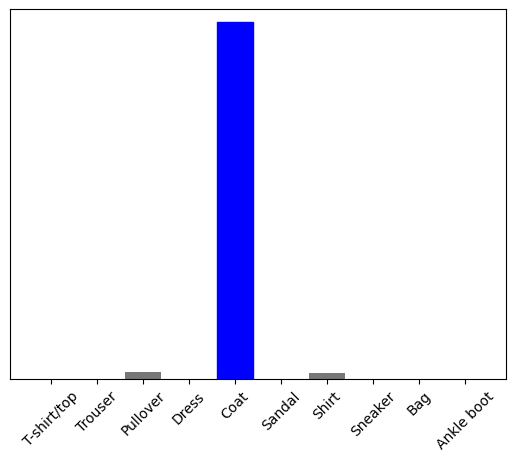

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [ ]:
np.argmax(predictions_single[0])

4

# 2. Use one epoch

Now I will examine how the number of epochs affects the prediction. I set it to one epoch.

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

Here is the difference:

In [ ]:
model2.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

1875/1875 [==============================] - 24s 5ms/step - loss: 0.4951 - accuracy: 0.8249


This gives accuracy: 0.8249, it's less than using 5 epochs.

# 3. Change the number of neurons

We will examine the hidden (second) layer.

* Case of 10 neurons:

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model3.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 20s 5ms/step - loss: 0.6658 - accuracy: 0.7772
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4786 - accuracy: 0.8352
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4458 - accuracy: 0.8436
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4327 - accuracy: 0.8503
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4284 - accuracy: 0.8498


This gives **accuracy: 0.8498** in the last epoch.

* Case of 64 neurons:

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model4.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 32s 6ms/step - loss: 0.5076 - accuracy: 0.8240
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3820 - accuracy: 0.8634
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3539 - accuracy: 0.8705
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3271 - accuracy: 0.8798
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3056 - accuracy: 0.8884


This gives **accuracy: 0.8884** in the last epoch.

* Case of 256 neurons:

In [ ]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model5.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 40s 11ms/step - loss: 0.4787 - accuracy: 0.8313
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3636 - accuracy: 0.8660
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3195 - accuracy: 0.8823
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2973 - accuracy: 0.8905
Epoch 5/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2827 - accuracy: 0.8945


This gives **accuracy: 0.8945** in the last epoch.

* Case of 512 neurons:

In [ ]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model6.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 37s 12ms/step - loss: 0.4693 - accuracy: 0.8328
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3569 - accuracy: 0.8698
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3191 - accuracy: 0.8821
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2978 - accuracy: 0.8899
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2791 - accuracy: 0.8970


This gives **accuracy: 0.8970** in the last epoch.

For more neurons we have better accuracy.

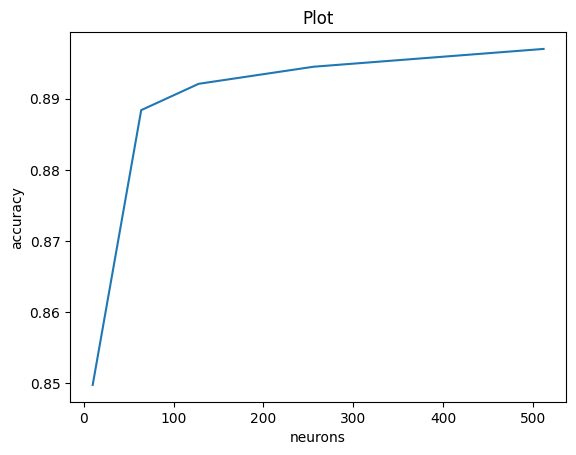

In [ ]:
neurons = [10, 64, 128, 256, 512]
accuracy = [0.8498, 0.8884, 0.8921, 0.8945, 0.8970]

plt.plot(neurons, accuracy)

plt.xlabel('neurons')
plt.ylabel('accuracy')
plt.title('Plot')

plt.show()

# 4. Additional dense layers

Add additional Dense layers between the Flatten and the final Dense, experimenting with different units in these layers.


* Added a same 128 neuron layer.



In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model3.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 39s 12ms/step - loss: 0.4844 - accuracy: 0.8269
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3590 - accuracy: 0.8698
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3257 - accuracy: 0.8796
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3031 - accuracy: 0.8867
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2834 - accuracy: 0.8948


This gives **accuracy: 0.8948** in the last epoch.

* Added a 512 neuron layer.

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model3.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 32s 11ms/step - loss: 0.4704 - accuracy: 0.8296
Epoch 2/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.3603 - accuracy: 0.8667
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3185 - accuracy: 0.8804
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3010 - accuracy: 0.8881
Epoch 5/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2800 - accuracy: 0.8955


This gives **accuracy: 0.8955** in the last epoch. Small improvement.

* Added two same 128 neuron layer.

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model3.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 22s 6ms/step - loss: 0.4822 - accuracy: 0.8273
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3663 - accuracy: 0.8652
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3294 - accuracy: 0.8786
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3026 - accuracy: 0.8868
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2917 - accuracy: 0.8911


This gives **accuracy: 0.8911** in the last epoch. This is worse than the previous.

# 5. Without normalizing

Don't normalize the pixel values, and see the effect that has.

We don't run the normalization cell.

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model3.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 24s 7ms/step - loss: 3.4797 - accuracy: 0.6739
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7333 - accuracy: 0.7180
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5894 - accuracy: 0.7861
Epoch 4/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5195 - accuracy: 0.8212
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5170 - accuracy: 0.8230


In [ ]:
test_loss, test_accuracy = model3.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 7ms/step - loss: 0.5548 - accuracy: 0.8090
Accuracy on test dataset: 0.8090000152587891


This gives **accuracy: 0.8090** in the last epoch. In the basic model we had **0.8765**.